In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler
    #RobustScaler
)
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

# modelos de regressão
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR, SVR                  
from sklearn.neighbors import KNeighborsRegressor

from xgboost import plot_importance
from sklearn.inspection import permutation_importance

from src.config import DADOS_TRATADOS
from src.graficos import (
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
    RANDOM_STATE,
)
from src.auxiliares import dataframe_coeficientes

#### Importando a base

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,model_year,transmission,fuel_type,city_l_100_km,highway_l_100_km,combined_l_100_km,co2_emissions_g_km,vehicle_class_grouped,engine_size_l_class,cylinders_class
0,2005,A,regular_gasoline,9.2,7.2,8.3,191,car,up_to_2L,up_to_4
1,2005,M,regular_gasoline,9.1,7.3,8.3,191,car,up_to_2L,up_to_4
2,2005,A,premium_gasoline,15.9,11.1,13.7,315,suv,up_to_4L,up_to_6
3,2005,AS,premium_gasoline,15.1,10.5,13.0,299,car,up_to_4L,up_to_6
4,2005,M,premium_gasoline,15.1,10.5,13.0,299,car,up_to_4L,up_to_6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20520 entries, 0 to 20519
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   model_year             20520 non-null  int64   
 1   transmission           20520 non-null  object  
 2   fuel_type              20520 non-null  object  
 3   city_l_100_km          20520 non-null  float64 
 4   highway_l_100_km       20520 non-null  float64 
 5   combined_l_100_km      20520 non-null  float64 
 6   co2_emissions_g_km     20520 non-null  int64   
 7   vehicle_class_grouped  20520 non-null  object  
 8   engine_size_l_class    20520 non-null  category
 9   cylinders_class        20520 non-null  category
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.3+ MB


#### Visualizando a distribuição dos dados das features numéricas para definir melhor preprocessamento

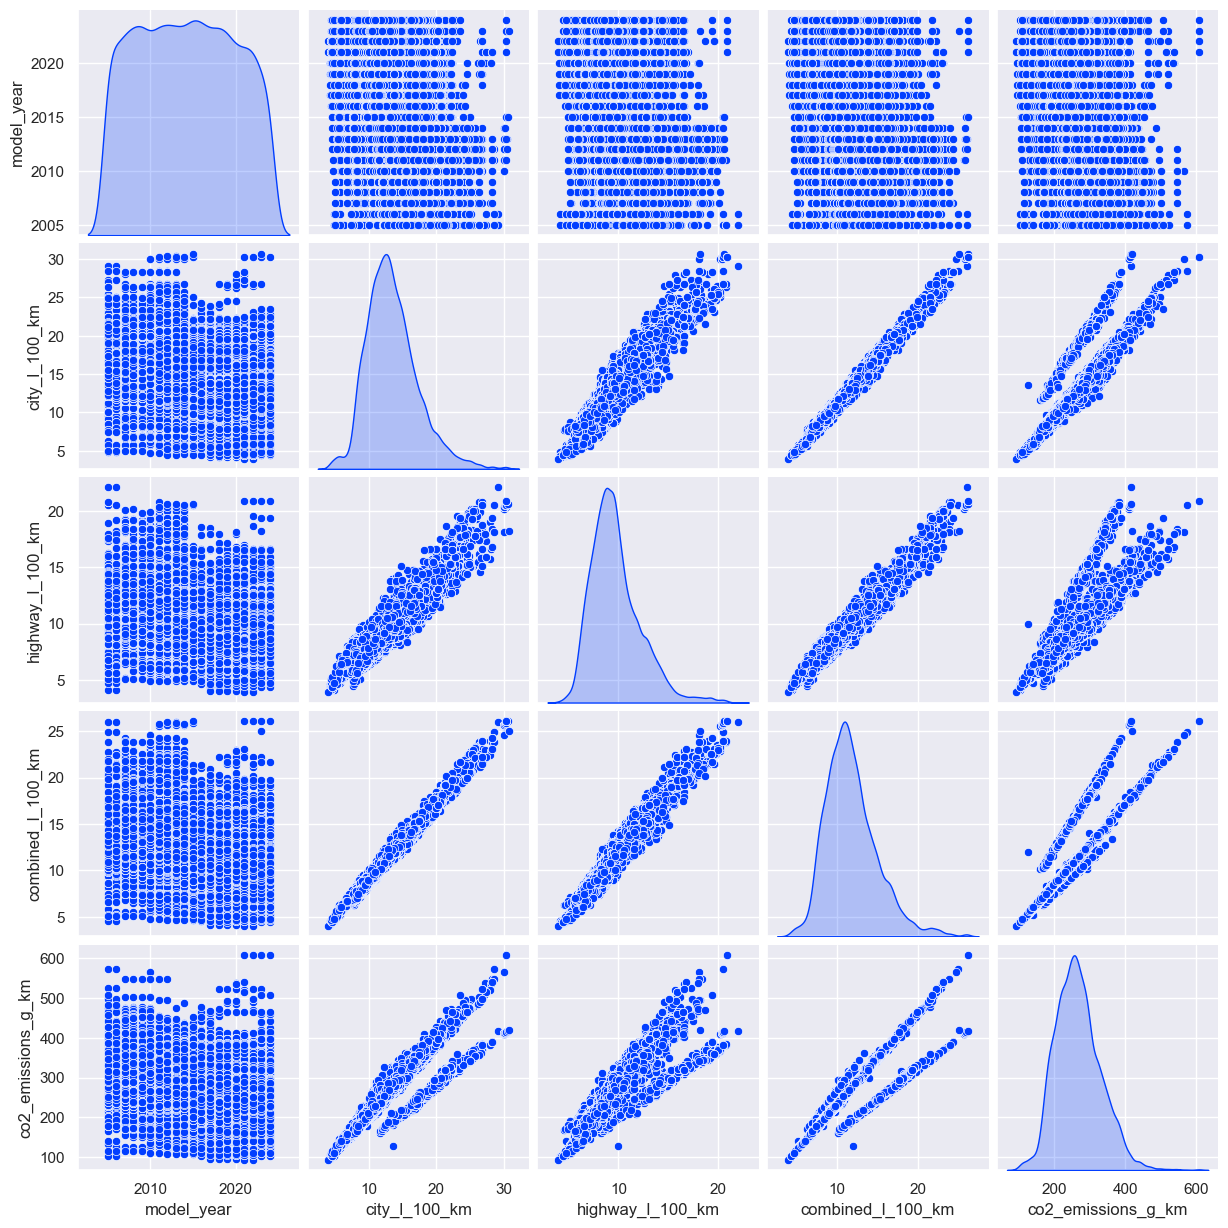

In [4]:
sns.pairplot(df, diag_kind='kde')

#### Separação das colunas por tipo

In [5]:
df.columns

Index(['model_year', 'transmission', 'fuel_type', 'city_l_100_km',
       'highway_l_100_km', 'combined_l_100_km', 'co2_emissions_g_km',
       'vehicle_class_grouped', 'engine_size_l_class', 'cylinders_class'],
      dtype='object')

In [6]:
X = df.drop(columns=["co2_emissions_g_km"])
y = df["co2_emissions_g_km"]

In [7]:
coluna_target = ["co2_emissions_g_km"]

coluna_one_hot_encoder = ['transmission', 'fuel_type', "vehicle_class_grouped"]

coluna_ordinal_encoder = ['engine_size_l_class', 'cylinders_class']

colunas_min_max_scaler = ['model_year']

colunas_power_transformer = ['city_l_100_km', 'highway_l_100_km', 'combined_l_100_km']   
# Poderia ser uma transformação simples como StandardScaler tbm

In [8]:
df['engine_size_l_class'].unique()

['up_to_2L', 'up_to_4L', 'up_to_6L', 'more_than_6L']
Categories (4, object): ['up_to_2L' < 'up_to_4L' < 'up_to_6L' < 'more_than_6L']

In [9]:
df['cylinders_class'].unique()

['up_to_4', 'up_to_6', 'up_to_8', 'more_than_8']
Categories (4, object): ['up_to_4' < 'up_to_6' < 'up_to_8' < 'more_than_8']

#### Definindo Etapas de Preprocessamento

In [10]:
categorias_ordinal_encoder = [
    ['up_to_2L', 'up_to_4L', 'up_to_6L', 'more_than_6L'],
    ['up_to_4', 'up_to_6', 'up_to_8', 'more_than_8']
]

In [11]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder,),
        ("ordinal_encoder",OrdinalEncoder(categories=categorias_ordinal_encoder),coluna_ordinal_encoder,),
        ("min_max_scaler",MinMaxScaler(),colunas_min_max_scaler,),
        ("power_transformer",PowerTransformer(),colunas_power_transformer,)
    ],
    remainder="passthrough"
)

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder,),
        ("ordinal_encoder",OrdinalEncoder(categories=categorias_ordinal_encoder),coluna_ordinal_encoder,),
    ],
    remainder="passthrough"
)

# OBS: Se não usarmos o parametro remainder="passthrough" no ColumnTransformer os resultadoss dos modelos de árvore irão piorar muito 

# Para bases menores é melhor usar o parametro drop='if_binary' no OneHotEncoder do que o 'first' pois pode ajudar na interpretação dos coeficientes dos modelos de regressão 
# Se é usado o parametro drop='first' os coeficientes do modelo de regressão serão criados como uma comparação pra coluna removida pelo 'first'

In [12]:
preprocessamento

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot_encoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['transmission', 'fuel_type',
                                  'vehicle_class_grouped']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['up_to_2L',
                                                             'up_to_4L',
                                                             'up_to_6L',
                                                             'more_than_6L'],
                                                            ['up_to_4',
                                                             'up_to_6',
                                                             'up_to_8',
                                                             'more_than_8']]),
                                 ['engine_size_l_class', 'cylinders_class']),
                                ('min_max_scaler', MinMaxScaler(),
                                 ['model_year']),
                                ('power_transformer', PowerTransformer(),
                                 ['city_l_100_km', 'highway_l_100_km',
                                  'combined_l_100_km'])])

In [13]:
preprocessamento_arvore

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot_encoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['transmission', 'fuel_type',
                                  'vehicle_class_grouped']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['up_to_2L',
                                                             'up_to_4L',
                                                             'up_to_6L',
                                                             'more_than_6L'],
                                                            ['up_to_4',
                                                             'up_to_6',
                                                             'up_to_8',
                                                             'more_than_8']]),
                                 ['engine_size_l_class', 'cylinders_class'])])

#### Definindo os Folds para Validação Cruzada

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Dicionário de Regressores

In [15]:
regressores = {
    "DummyRegressor": {
        'regressor': DummyRegressor(strategy='mean'),
        'preprocessor': preprocessamento,
        'target_transformer': None,
    },
    "LinearRegression": {
        'regressor': LinearRegression(),
        'preprocessor': preprocessamento,
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    "Ridge": {
        'regressor': Ridge(),
        'preprocessor': preprocessamento,
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    "Lasso": {
        'regressor': Lasso(),
        'preprocessor': preprocessamento,
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    "DecisionTreeRegressor": {
        'regressor': DecisionTreeRegressor(random_state=RANDOM_STATE),
        'preprocessor': preprocessamento_arvore,
        'target_transformer': None,
    },
    "LightGBMRegressor": {
        'regressor': LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
        'preprocessor': preprocessamento_arvore,
        'target_transformer': None,
    },
    "XGBRegressor": {
        'regressor': XGBRegressor(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
        'preprocessor': preprocessamento_arvore,
        'target_transformer': None,
    },
    #"SVCRegressor": {
    #    'regressor': SVR(),
    #    'preprocessor': preprocessamento,
    #    'target_transformer': QuantileTransformer(output_distribution='normal'),
    #},
    "KNeighborsRegressor": {
        'regressor': KNeighborsRegressor(),
        'preprocessor': preprocessamento,
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    "LinearSVR": {
        'regressor': LinearSVR(random_state=RANDOM_STATE),
        'preprocessor': preprocessamento,
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    }, 
}

In [16]:
resultados = {nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo) 
              for nome_modelo, modelo in regressores.items()}


df_resultados = organiza_resultados(resultados)
df_resultados

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, 

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.257177,0.045844,-0.000004,-49.348356,-62.362932,0.303021
1,DummyRegressor,0.225944,0.037714,-0.00037,-49.62071,-63.156872,0.263658
2,DummyRegressor,0.213068,0.035797,-0.000016,-50.059719,-63.889538,0.248865
3,DummyRegressor,0.213784,0.033185,-0.000045,-50.528288,-63.968216,0.246969
4,DummyRegressor,0.24972,0.033916,-0.000205,-50.694893,-64.138489,0.283636
5,LinearRegression,0.209882,0.036564,0.996116,-2.526375,-3.886808,0.246446
6,LinearRegression,0.304168,0.039898,0.996209,-2.59807,-3.887801,0.344065
7,LinearRegression,0.287279,0.032911,0.996417,-2.476931,-3.824271,0.320189
8,LinearRegression,0.320153,0.039893,0.996596,-2.458359,-3.732272,0.360046
9,LinearRegression,0.26956,0.037899,0.996229,-2.48062,-3.93807,0.307459


In [17]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
Lasso,0.267634,0.0382,-0.006732,-49.843309,-63.712474,0.305834
DummyRegressor,0.231939,0.037291,-0.000128,-50.050393,-63.503209,0.26923
KNeighborsRegressor,0.245783,1.376893,0.995349,-2.080864,-4.31134,1.622676
Ridge,0.270426,0.038389,0.996039,-2.592031,-3.992706,0.308815
LinearSVR,2.967098,0.036585,0.996113,-2.263719,-3.94806,3.003683
LinearRegression,0.278208,0.037433,0.996313,-2.508071,-3.853845,0.315641
LightGBMRegressor,0.681172,0.043191,0.999357,-0.78758,-1.602916,0.724364
DecisionTreeRegressor,0.227677,0.037649,0.999422,-0.382838,-1.512902,0.265327
XGBRegressor,0.459902,0.039879,0.999586,-0.584628,-1.274885,0.499782


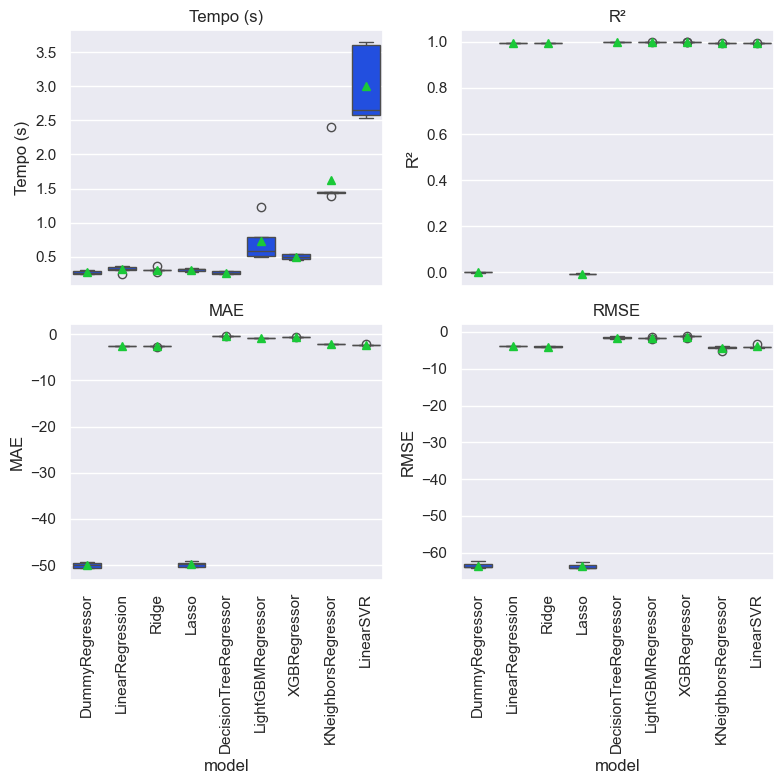

In [18]:
plot_comparar_metricas_modelos(df_resultados)

**Análise dos Resultados**:
- Modelos baseado em árvores obtiveram melhores resultados
- Analisando pela métrica o melhor modelo foi o XGBRegressor
- Os resultados já estão bem staisfatóros com os modelos sem otimização, ainda assim vou buscar melhorar um pouco

#### Otimizando o melhor modelo: XGBRegressor

In [19]:
param_grid = {
    'reg__n_estimators': [25, 50, 100],         # número de árvores
    'reg__learning_rate': [0.01, 0.1, 0.2],     # taxa de aprendizado (eta) 
    'reg__max_depth': [5, 7, 10],               # profundidade máxima da árvore
    'reg__gamma': [0, 0.1, 0.2],                # redução mínima de perda para split
    'reg__reg_alpha': [0, 0.1, 0.5, 1],         # regulização L1
    'reg__reg_lambda': [0, 0.1, 1, 5],          # regulização L2
}

In [20]:
regressor = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

grid_search = grid_search_cv_regressor(
    regressor=regressor,
    param_grid=param_grid,
    preprocessor=preprocessamento_arvore,
    target_transformer=None,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot_encoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['transmission',
                                                                          'fuel_type',
                                                                          'vehicle_class_grouped']),
                                                                        ('ordinal_encoder',
                                                                         OrdinalEncoder(categories=[['up_to_2L',
                                                                                                     'up_to_4L',
                                                                                                     'up_to_6L',
                                                                                                     'mor...
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'reg__gamma': [0, 0.1, 0.2],
                         'reg__learning_rate': [0.01, 0.1, 0.2],
                         'reg__max_depth': [5, 7, 10],
                         'reg__n_estimators': [25, 50, 100],
                         'reg__reg_alpha': [0, 0.1, 0.5, 1],
                         'reg__reg_lambda': [0, 0.1, 1, 5]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [ ]:
grid_search.best_params_

{'reg__gamma': 0.1,
 'reg__learning_rate': 0.2,
 'reg__max_depth': 10,
 'reg__n_estimators': 100,
 'reg__reg_alpha': 0.5,
 'reg__reg_lambda': 5}

In [ ]:
grid_search.best_score_

-1.2158037900924683

In [ ]:
grid_search.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'),
                                  ['transmission', 'fuel_type',
                                   'vehicle_class_grouped']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['up_to_2L',
                                                              'up_to_4L',
                                                              'up_to_6L',
                                                              'more_than_6L'],
                                                             ['up_to_4',
                                                              'up_to_6',
                                                              'up_to_8',
                                                              'more_than_8']]),
                                  ['engin

#### Analisando resultados do modelo

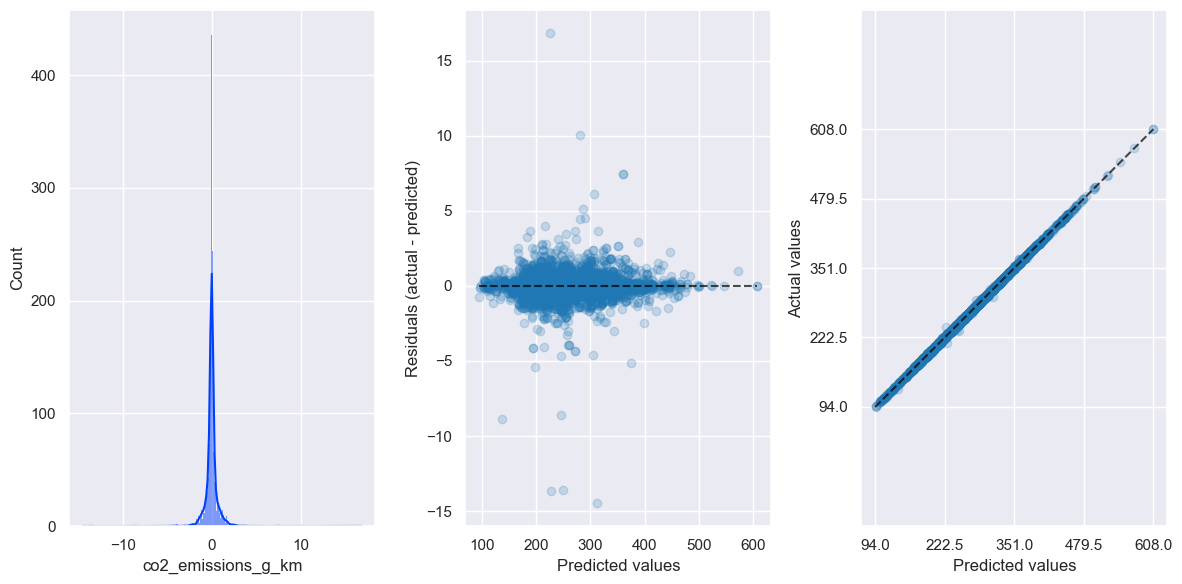

In [ ]:
plot_residuos_estimador(grid_search.best_estimator_, X, y)     #, eng_formatter=True)

#### Analisando Features mais Importantes

In [ ]:
feature_names = grid_search.best_estimator_["preprocessor"].get_feature_names_out()
feature_names

array(['one_hot_encoder__transmission_A',
       'one_hot_encoder__transmission_AM',
       'one_hot_encoder__transmission_AS',
       'one_hot_encoder__transmission_AV',
       'one_hot_encoder__transmission_M',
       'one_hot_encoder__fuel_type_diesel',
       'one_hot_encoder__fuel_type_ethanol',
       'one_hot_encoder__fuel_type_premium_gasoline',
       'one_hot_encoder__fuel_type_regular_gasoline',
       'one_hot_encoder__vehicle_class_grouped_car',
       'one_hot_encoder__vehicle_class_grouped_pickup_truck',
       'one_hot_encoder__vehicle_class_grouped_special_purpose',
       'one_hot_encoder__vehicle_class_grouped_station_wagon',
       'one_hot_encoder__vehicle_class_grouped_suv',
       'one_hot_encoder__vehicle_class_grouped_van',
       'ordinal_encoder__engine_size_l_class',
       'ordinal_encoder__cylinders_class', 'remainder__model_year',
       'remainder__city_l_100_km', 'remainder__highway_l_100_km',
       'remainder__combined_l_100_km'], dtype=object)

In [ ]:
importancia_features = grid_search.best_estimator_['reg'].get_booster().get_score()
importancia_features

{'f0': 340.0,
 'f1': 236.0,
 'f2': 320.0,
 'f3': 108.0,
 'f4': 168.0,
 'f5': 304.0,
 'f6': 256.0,
 'f7': 311.0,
 'f8': 30.0,
 'f9': 208.0,
 'f10': 153.0,
 'f11': 35.0,
 'f12': 49.0,
 'f13': 168.0,
 'f14': 44.0,
 'f15': 375.0,
 'f16': 248.0,
 'f17': 2776.0,
 'f18': 2462.0,
 'f19': 2168.0,
 'f20': 2938.0}

In [ ]:
list(importancia_features.values())

[340.0,
 236.0,
 320.0,
 108.0,
 168.0,
 304.0,
 256.0,
 311.0,
 30.0,
 208.0,
 153.0,
 35.0,
 49.0,
 168.0,
 44.0,
 375.0,
 248.0,
 2776.0,
 2462.0,
 2168.0,
 2938.0]

In [ ]:
indices_features = np.argsort(list(importancia_features.values()))[::-1]
indices_features

array([20, 17, 18, 19, 15,  0,  2,  7,  5,  6, 16,  1,  9, 13,  4, 10,  3,
       12, 14, 11,  8], dtype=int64)

In [ ]:
sorted_feature_names = feature_names[indices_features]
sorted_feature_names

array(['remainder__combined_l_100_km', 'remainder__model_year',
       'remainder__city_l_100_km', 'remainder__highway_l_100_km',
       'ordinal_encoder__engine_size_l_class',
       'one_hot_encoder__transmission_A',
       'one_hot_encoder__transmission_AS',
       'one_hot_encoder__fuel_type_premium_gasoline',
       'one_hot_encoder__fuel_type_diesel',
       'one_hot_encoder__fuel_type_ethanol',
       'ordinal_encoder__cylinders_class',
       'one_hot_encoder__transmission_AM',
       'one_hot_encoder__vehicle_class_grouped_car',
       'one_hot_encoder__vehicle_class_grouped_suv',
       'one_hot_encoder__transmission_M',
       'one_hot_encoder__vehicle_class_grouped_pickup_truck',
       'one_hot_encoder__transmission_AV',
       'one_hot_encoder__vehicle_class_grouped_station_wagon',
       'one_hot_encoder__vehicle_class_grouped_van',
       'one_hot_encoder__vehicle_class_grouped_special_purpose',
       'one_hot_encoder__fuel_type_regular_gasoline'], dtype=object)

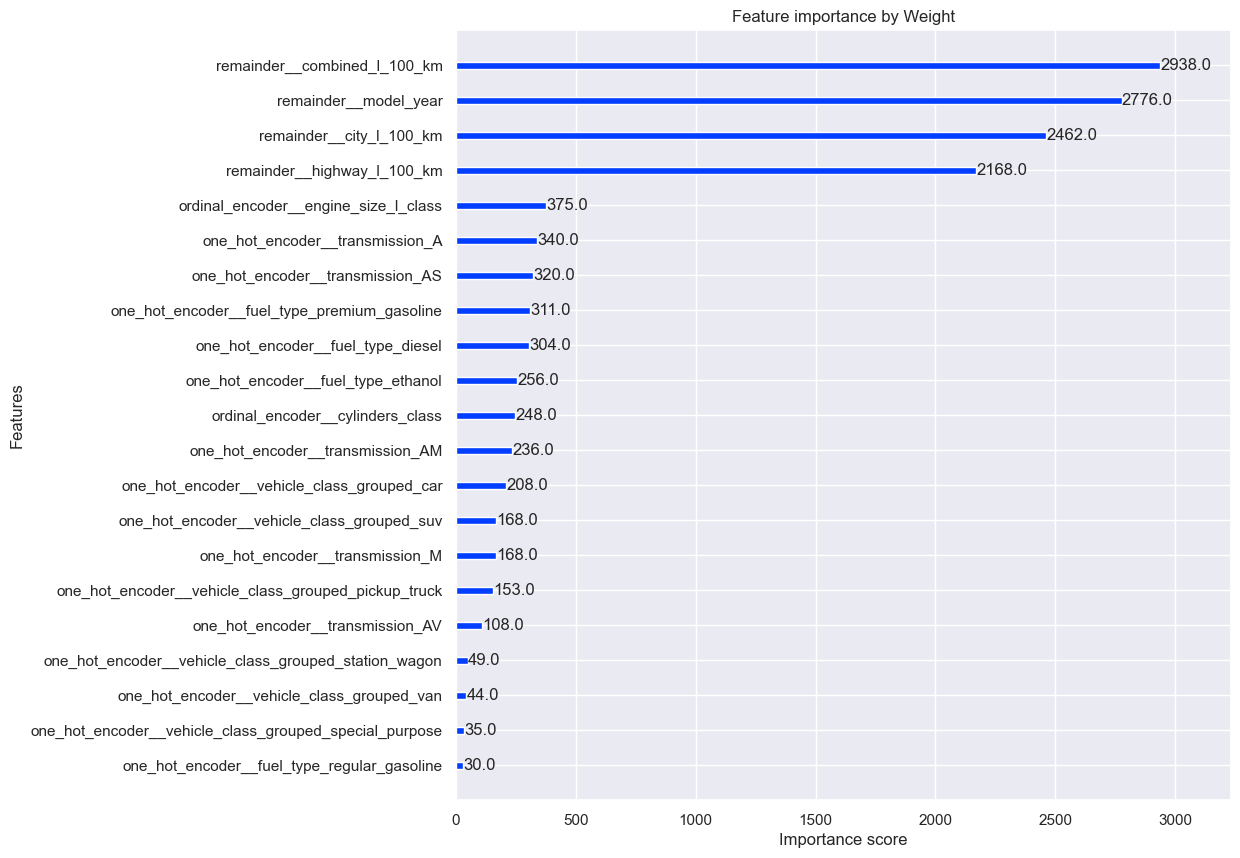

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["reg"],
    ax=ax,
    importance_type="weight",
    title="Feature Importance by Weight - Detecção de Features mais Relevantes"
)

plt.yticks(
    np.arange(len(grid_search.best_estimator_['preprocessor'].get_feature_names_out())),            # Quantidade de ticks
    sorted_feature_names[::-1]                                                                      # Nome de cada ticks
)

plt.show()

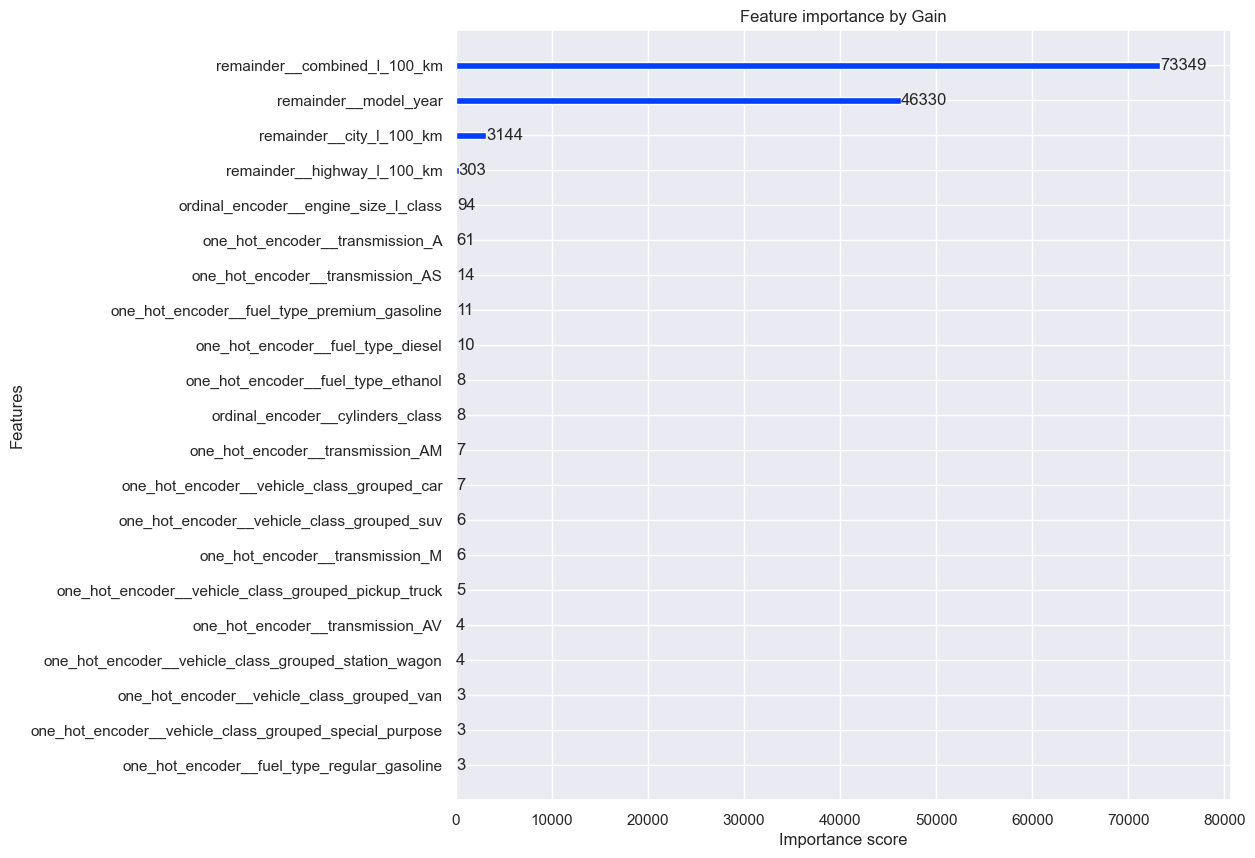

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["reg"],
    ax=ax,
    importance_type="gain",
    title="Feature Importance by Gain - Detecção de Features mais Relevantes",
    values_format = "{v:.0f}"
)

plt.yticks(
    np.arange(len(grid_search.best_estimator_['preprocessor'].get_feature_names_out())),            # Quantidade de ticks
    sorted_feature_names[::-1]                                                                      # Nome de cada ticks
)

plt.show()

#### Permutation Importace

In [ ]:
perm_imp = permutation_importance(
    grid_search.best_estimator_,
    X,
    y,
    n_repeats=10,
    random_state=RANDOM_STATE
)

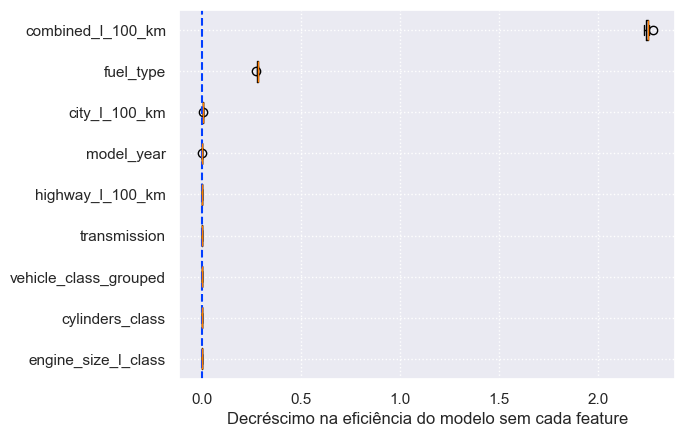

In [ ]:
fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo na eficiência do modelo eliminando cada feature")
ax.grid(True, linestyle=":")
ax.set_title("Permutation Importance - Detecção Features mais Relevantes")

plt.show()

#### **Conclusões**
- Podemos concluir que os carros mais econômicos são também aqueles que menos geram emissão de CO2 para a atmosfera, e os ano do carro também tem grande influencia para o modelo determinar essa métrica. Aparentemente o tipo de combustível também exerce um pouco de influência se formos analisar os resultados do permutation importance.

#### Exportando modelo

In [ ]:
from joblib import dump

dump(grid_search.best_estimator_, "../modelos/xgb_regressor.joblib")         # TESTAR CÓDIGO ABAIXO

['../modelos/xgb_regressor.joblib']